### Project Title: Grouping StackOverflow Comments to improve Software Develpment Practices

#### We have merged post and comments dataset based on post id which has more than 5 comments and saved it as Comments_Ds.csv

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Read the posts.csv and comments.csv files into DataFrames
posts_df = pd.read_csv('posts_stack.csv')
comments_df = pd.read_csv('comments_stack.csv')

In [2]:
posts_df.shape

(561227, 17)

In [3]:
comments_df.shape

(930021, 6)

In [4]:
posts_df.columns

Index(['Unnamed: 0', 'id', 'post_type_id', 'accepted_answer_id', 'parent_id',
       'creation_date', 'score', 'view_count', 'owner_user_id', 'tags',
       'answer_count', 'comment_count', 'favorite_count', 'closed_date',
       'community_owned_date', 'title', 'body'],
      dtype='object')

In [5]:
comments_df.columns

Index(['Unnamed: 0', 'id', 'post_id', 'text', 'creation_date', 'user_id'], dtype='object')

In [4]:
# Select the required columns from the posts and comments DataFrames
posts = posts_df[['id', 'post_type_id', 'parent_id', 'score', 'title', 'body', 'tags', 'comment_count']]
comments = comments_df[['id', 'post_id', 'text', 'user_id']]

In [5]:
# Rename the columns in the comments DataFrame to match the column names in the posts DataFrame
comments = comments.rename(columns={'id': 'comment_id'})

In [6]:
# Join the posts and comments DataFrames on the 'Id' column
posts_comments = pd.merge(posts, comments, left_on='id', right_on='post_id')

# Filter for only the posts that have more than 5 comments
final_posts = posts_comments[posts_comments['comment_count'] > 4]


In [7]:
# Filter for only the posts that have more than 5 comments
po_co = posts_comments[posts_comments['comment_count'] > 5]

In [8]:
po_co.columns

Index(['id', 'post_type_id', 'parent_id', 'score', 'title', 'body', 'tags',
       'comment_count', 'comment_id', 'post_id', 'text', 'user_id'],
      dtype='object')

In [9]:
sorted_df = po_co.sort_values(by=['post_id'])

In [12]:
sorted_df.shape

(345529, 12)

In [11]:
# save the dataframe to an excel file
sorted_df.to_csv('Comments_Ds.csv', index=False)

In [34]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Read the comments.csv files into DataFrames
df_comments = pd.read_csv('Comments_Ds.csv')



#### Below blocks shows the total number of comments and posts used in this grouping

In [35]:
df_comments.shape

(345529, 12)

In [72]:
df_comments['post_id'].nunique()

41794

In [36]:
df_comments.columns

Index(['id', 'post_type_id', 'parent_id', 'score', 'title', 'body', 'tags',
       'comment_count', 'comment_id', 'post_id', 'text', 'user_id'],
      dtype='object')

In [37]:
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DHANASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DHANASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DHANASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Text Preprocessing

In [38]:
# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
        
    # Remove punctuation except for @ and #
    #text = re.sub(r'[^\w\s#@]', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))    
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize text into individual words
    words = nltk.word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a single string separated by space
    text = ' '.join(words)
    
    return text


# Preprocess comments
df_comments['preprocessed_text'] = df_comments['text'].apply(preprocess)

#### Calculating length for the Comment Text to use it as a feature

In [39]:
 # Calculate the length of each comment
df_comments['length'] = df_comments['preprocessed_text'].apply(len)


In [40]:
df_comments.head(1)

,id,post_type_id,parent_id,score,title,body,tags,comment_count,comment_id,post_id,text,user_id,preprocessed_text,length
0,11,1,-999,31,How can I tweak my Linux desktop to be more re...,<p>I have the experience that Linux works fine...,<linux><kernel><performance><io><swap>,8,849,11,This is a known issue with the linux kernel......,29,known issue linux kernel believe read recently...,84


#### Clustering the comments for each post and we have used '3' clusters

In [41]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the number of clusters
num_clusters = 3

# Concatenate the 'preprocessed_text', 'length', and 'user_id' columns into a single text column
df_comments['feature_text'] = df_comments.apply(lambda x: x['preprocessed_text'] + '|' + str(x['length']) + '|' + str(x['user_id']), axis=1)

# Create a TfidfVectorizer object to convert comments to a numeric matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')

# Create a dictionary to store the cluster labels for each post
post_clusters_pre = {}

# Group the comments by post_id
grouped_comments_pre = df_comments.groupby('post_id')

In [42]:
# Loop through each post's comments and perform clustering
for post_id, group in grouped_comments_pre:
    # Convert the comments to a matrix of TF-IDF features
    comment_features = vectorizer.fit_transform(group['feature_text'])

    # Concatenate the 'length' and 'user_id' columns with the TF-IDF matrix
    comment_length = group['length'].values.reshape(-1, 1)
    comment_user = group['user_id'].values.reshape(-1, 1)
    comment_features = np.concatenate((comment_features.toarray(), comment_length, comment_user), axis=1)

    # Perform k-means clustering on the comment features
    km = KMeans(n_clusters=num_clusters)
    km.fit(comment_features)

    # Create a dictionary to store the cluster labels for this post
    post_labels = {}

    # Loop through each comment in this post and store its cluster label
    for i, comment_id in enumerate(group['comment_id']):
        post_labels[comment_id] = km.labels_[i]

    # Add the post dictionary to the post_clusters dictionary
    post_clusters_pre[post_id] = post_labels


#### List is created for each post, comment and its label and converted to dataframe for assessing the accuracy

In [51]:
# Create an empty list to store the data
data = []

# Loop through each post and its labels
for post_id, post_labels in post_clusters_pre.items():
    # Loop through each comment and its label
    for comment_id, label in post_labels.items():
        # Append the data to the list
        data.append({
            'post_id': post_id,
            'comment_id': comment_id,
            'cluster_label': label
        })

# Convert the list to a dataframe
df_clusters_pre = pd.DataFrame(data)


#### We have manually labelled 1004 posts to evaluate the clustering algorithm

In [58]:
df_eval_clusters = pd.read_csv('FinalEvaldata.csv')

In [59]:
df_eval_clusters.shape

(8416, 3)

In [60]:
df_eval_clusters['post_id'].nunique()

1004

In [61]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Merge the two dataframes on post_id and comment_id
df_merged = df_clusters_pre.merge(df_eval_clusters, on=['post_id', 'comment_id'])

In [62]:

# Compute the ARI and AMI scores
ari = adjusted_rand_score(df_merged['cluster_label_x'], df_merged['cluster_label_y'])
ami = adjusted_mutual_info_score(df_merged['cluster_label_x'], df_merged['cluster_label_y'])

# Print the scores
print("ARI: ", ari)
print("AMI: ", ami)


ARI:  0.9175833703538012
AMI:  0.8634694222118062


In [66]:
# Compute the accuracy of the clustering
accuracy = (df_merged['cluster_label_x'] == df_merged['cluster_label_y']).mean()
print('Accuracy:', accuracy*100)

Accuracy: 97.13640684410646


#### Visualization of the Result using Confusion Matrix

In [70]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df_merged['cluster_label_y'], df_merged['cluster_label_x'])

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[3537   32   13    0]
 [  57 2592   32    0]
 [  59   47 2046    0]
 [   0    1    0    0]]


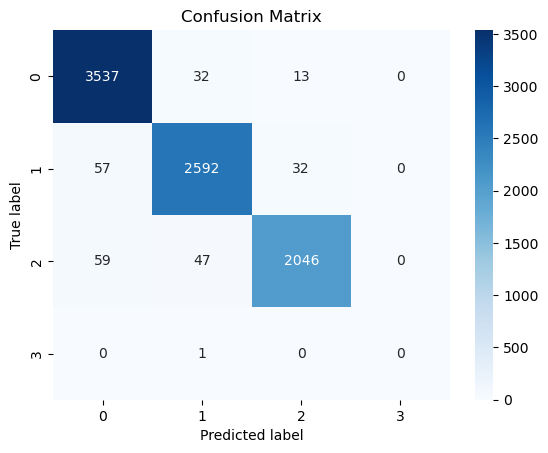

In [71]:
import seaborn as sns
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set the axis labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


#### The confusion matrix shows that:

#### 3,537 instances of class 0 were correctly classified as class 0, 57 were incorrectly classified as class 1, and 59 were incorrectly classified as class 2.
#### 2,592 instances of class 1 were correctly classified as class 1, 32 were incorrectly classified as class 0, and 47 were incorrectly classified as class 2.
#### 2,046 instances of class 2 were correctly classified as class 2, 13 were incorrectly classified as class 0, and 32 were incorrectly classified as class 1.
#### 1 instance of class 3 was incorrectly classified as class 1.

#### Recommending most relevant comment for the selected comment within the post clusters

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Define a function to compute the cosine similarity between two texts
def compute_similarity(text1, text2):
    # Create a TfidfVectorizer object to compute the TF-IDF vectors
    vectorizer = TfidfVectorizer()

    # Create the TF-IDF vectors for the two texts
    tfidf = vectorizer.fit_transform([text1, text2])

    # Compute the cosine similarity between the two vectors
    cosine_sim = cosine_similarity(tfidf[0], tfidf[1])[0][0]

    return cosine_sim

In [77]:
def recommend_comments(post_id, comment_id):
    # Get the post and comments data
    comments_data = df_comments.loc[df_comments['post_id'] == post_id]

    # Get the selected comment and its text
    selected_comment = comments_data.loc[comments_data['comment_id'] == comment_id]
    selected_comment_text = selected_comment['preprocessed_text'].values[0]

    # Compute the similarity between the selected comment and all other comments in the post
    similarities = comments_data.apply(lambda row: compute_similarity(selected_comment_text, row['preprocessed_text']), axis=1)

    # Get the top 5 most similar comments
    top_indices = similarities.argsort()[-6:-1][::-1] # We select the top 6 comments to exclude the selected comment itself
    top_comments = comments_data.iloc[top_indices]['text'].values.tolist()

    # Return the recommended comments
    return top_comments



In [84]:
result = recommend_comments(11, 852)
i=1;
for comment in result:
    print(str(i) +  ". " + comment)
    i=i+1

1. basically those articles talk about patches that are going into 2.6.36 so when that comes out get that (unless you dare to run an RC or from master)
2. memory is cheap these days.  if you have a fairly modern motherboard (e.g. one that takes DDR3 RAM) then you can replace your 8GB RAM with 16GB for somewhere between $40 (just add 2 more 4GB sticks) and $100 (if you have to replace all your RAM with two shiny new 8GB sticks).  You could spend hours or days stuffing around with tweaking and tuning and not get anywhere near the benefit of just adding more RAM.
3. if you can't add more RAM for some reason, another option is to add an SSD - use it for your boot/OS disk and for swap space.  they're a lot faster than mechanical hard disks.
4. progress http://unix.stackexchange.com/questions/5565/whats-the-progress-regarding-improving-system-performance-responsiveness-during
5. I have 8GB of RAM and the culprits are the usual apps (webbrowsers like Firefox and Chrome, e-mail clients like th

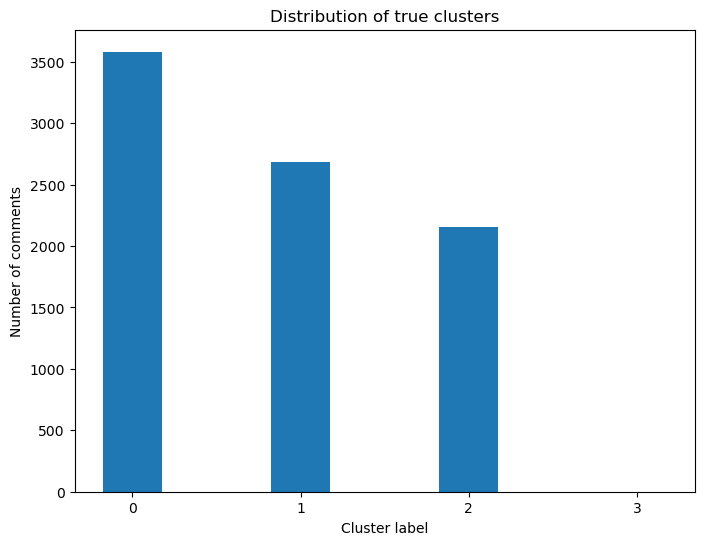

In [92]:
import matplotlib.pyplot as plt

# Get the cluster counts
cluster_counts = df_eval_clusters['cluster_label'].value_counts().sort_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
x = cluster_counts.index
width = 0.35

# Plot the clusters
ax.bar(x, cluster_counts, width)

# Add labels and title
ax.set_xlabel('Cluster label')
ax.set_ylabel('Number of comments')
ax.set_title('Distribution of true clusters')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.show()


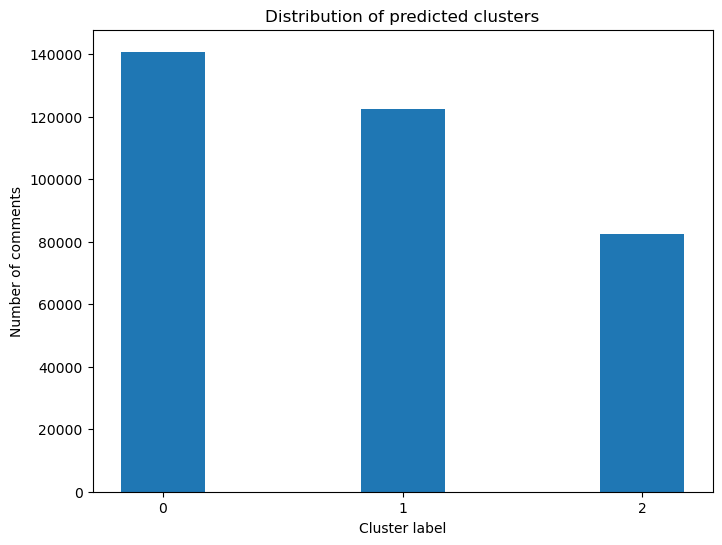

In [93]:
import matplotlib.pyplot as plt

# Get the cluster counts
cluster_counts = df_clusters_pre['cluster_label'].value_counts().sort_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
x = cluster_counts.index
width = 0.35

# Plot the clusters
ax.bar(x, cluster_counts, width)

# Add labels and title
ax.set_xlabel('Cluster label')
ax.set_ylabel('Number of comments')
ax.set_title('Distribution of predicted clusters')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.show()
